In [1]:
!pip install pandas_datareader

In [2]:
# Import Libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as fred 

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

plt.style.use("seaborn-v0_8") 

In [3]:
# We will start in 1970 to ensure that we have data for the 1970s stagflation period
start_macro = "1970-01-01" 
end_date = None # This means we use latest data from FRED

In [4]:
def fetch_macro_data(start_date=start_macro, end_date=end_date):
    """
    Fetch macro data from FRED and build Growth and Inflation proxies.

    - Growth proxy: Industrial Production (INDPRO) YoY % change
    - Inflation proxy: CPI (CPIAUCSL) YoY % change

    Steps:
        1. Download monthly levels from FRED.
        2. Drop any rows with missing values.
        3. Compute YoY log changes (12-month difference of logs × 100).
           This gives smoother percentage changes and is standard in macro.
    """
    series_list = ["INDPRO", "CPIAUCSL"]

    # Fetch monthly levels from FRED
    macro_data = fred.DataReader(series_list, "fred", start_date, end_date)

    # Ensure we only keep dates where both series are available
    macro_data = macro_data.dropna()

    # Compute YoY log changes * 100 to approximate percentage changes
    macro_data["growth_yoy"] = (
        np.log(macro_data["INDPRO"]).diff(12) * 100.0
    )
    macro_data["inflation_yoy"] = (
        np.log(macro_data["CPIAUCSL"]).diff(12) * 100.0
    )

    # Drop the first 12 months where YoY changes are NaN
    macro_data = macro_data.dropna()

    return macro_data

In [5]:
# Actually fetch the data
macro_data = fetch_macro_data()

print("Macro data (first few rows):")
print(macro_data.head())
print("\nData coverage:")
print(macro_data.index.min(), "→", macro_data.index.max())

Macro data (first few rows):
             INDPRO  CPIAUCSL  growth_yoy  inflation_yoy
DATE                                                    
1971-01-01  37.5753      39.9   -1.110239       5.142521
1971-02-01  37.5037      39.9   -1.235151       4.616204
1971-03-01  37.4631      40.0   -1.213541       4.342956
1971-04-01  37.6735      40.1   -0.396045       4.071809
1971-05-01  37.8646      40.3    0.226589       4.309919

Data coverage:
1971-01-01 00:00:00 → 2025-09-01 00:00:00


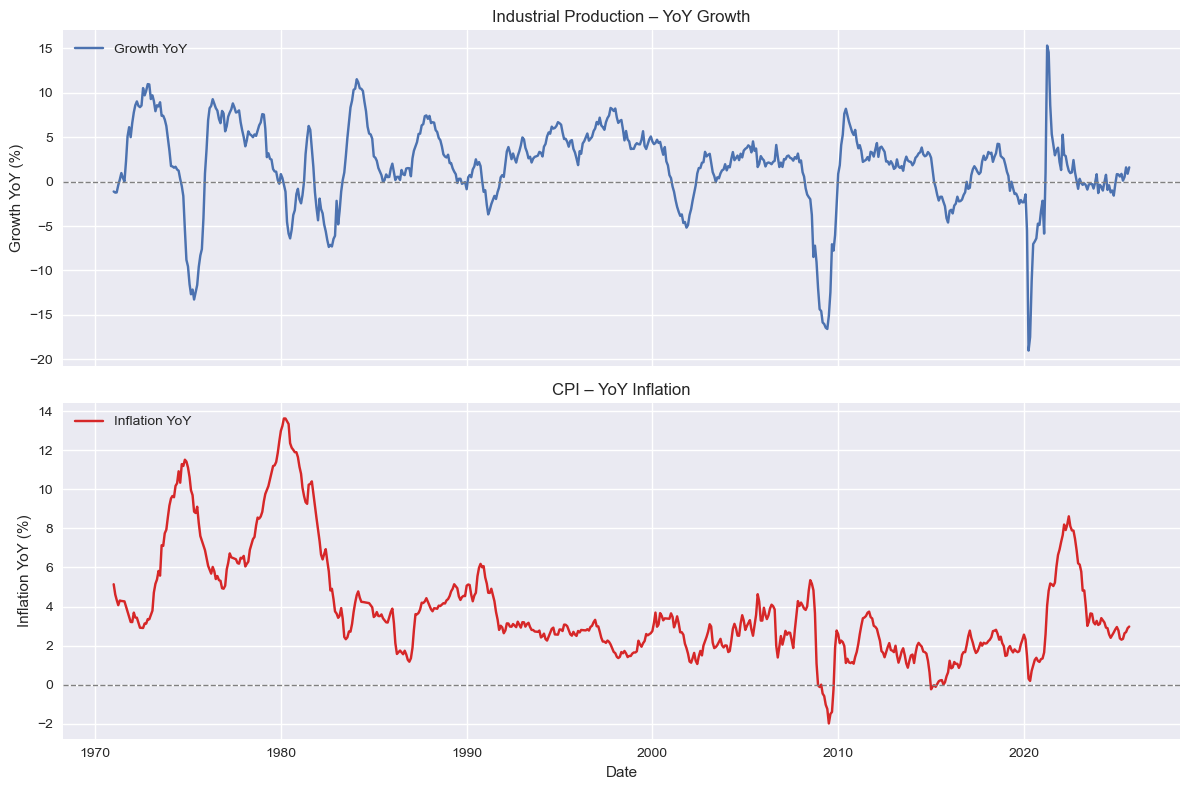

In [6]:
def plot_macro_series(macro_data):
    """
    Plot Growth YoY (Industrial Production) and Inflation YoY (CPI).

    Purpose:
        - Visual sanity check before modelling.
        - See big episodes: 1970s stagflation, 2008 crisis, 2020 Covid shock,
          2022 inflation spike, etc.
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Growth YoY
    axes[0].plot(macro_data.index, macro_data["growth_yoy"], label="Growth YoY")
    axes[0].axhline(0.0, color="grey", linestyle="--", linewidth=1)
    axes[0].set_ylabel("Growth YoY (%)")
    axes[0].set_title("Industrial Production – YoY Growth")
    axes[0].legend(loc="upper left")

    # Inflation YoY
    axes[1].plot(macro_data.index, macro_data["inflation_yoy"], label="Inflation YoY", color="tab:red")
    axes[1].axhline(0.0, color="grey", linestyle="--", linewidth=1)
    axes[1].set_ylabel("Inflation YoY (%)")
    axes[1].set_title("CPI – YoY Inflation")
    axes[1].legend(loc="upper left")

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

plot_macro_series(macro_data)

In [7]:
def fit_growth_regime_model(macro_data, k_list=(3, 4)):
    """
    Fit a Markov-switching regression (Gaussian HMM) on Growth YoY.

    Observed series:
        - growth_yoy (Industrial Production YoY %)

    Model:
        - K hidden regimes (values in k_list)
        - Regime-specific intercepts (trend='c')
        - Regime-specific variances (switching_variance=True):
          recessions / stagflation regimes are typically more volatile.

    We:
        - Try each K in k_list
        - Use search_reps + EM to improve convergence
        - Select the model with the lowest BIC among those that converged
    """
    growth_series = macro_data["growth_yoy"].astype(float)

    best_result = None
    best_k = None
    best_bic = np.inf

    for k in k_list:
        print(f"\n--- Fitting {k}-regime model ---")
        try:
            model = MarkovRegression(
                endog=growth_series,
                k_regimes=k,
                trend="c",               # regime-specific mean
                switching_variance=True  # key: volatility differs by regime
            )

            result = model.fit(
                maxiter=1000,
                em_iter=20,     # a few EM iterations first
                search_reps=50, # random restarts for better starting values
                disp=False
            )

            print(f"{k} regimes: loglike={result.llf:.2f}, AIC={result.aic:.2f}, BIC={result.bic:.2f}")

            if result.bic < best_bic:
                best_bic = result.bic
                best_result = result
                best_k = k

        except Exception as e:
            print(f"Failed to fit {k}-regime model: {e}")

    if best_result is None:
        raise RuntimeError("All candidate regime models failed to converge.")

    print(f"\nSelected {best_k}-regime model (lowest BIC = {best_bic:.2f}).\n")
    print(best_result.summary())

    return best_result


# Try fitting again with the revised function
regime_model_result = fit_growth_regime_model(macro_data, k_list=(3, 4))



--- Fitting 3-regime model ---


C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM itera

3 regimes: loglike=-1487.22, AIC=2998.43, BIC=3052.29

--- Fitting 4-regime model ---


C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
C:\Users\jonat\miniconda3\Lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM itera

4 regimes: loglike=-1344.38, AIC=2728.76, BIC=2818.52

Selected 4-regime model (lowest BIC = 2818.52).

                        Markov Switching Model Results                        
Dep. Variable:             growth_yoy   No. Observations:                  657
Model:               MarkovRegression   Log Likelihood               -1344.381
Date:                Sat, 06 Dec 2025   AIC                           2728.762
Time:                        15:28:51   BIC                           2818.515
Sample:                    01-01-1971   HQIC                          2763.558
                         - 09-01-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2495      

In [8]:
def attach_regime_probabilities(macro_data, model_result):
    """
    Attach smoothed and filtered regime probabilities to the macro data.

    Added columns:
        - 'Regime_0', 'Regime_1', ...       (smoothed probabilities)
        - 'FiltRegime_0', 'FiltRegime_1', ... (filtered probabilities)
        - 'Regime' (int) = argmax of smoothed probabilities (most likely regime)

    NOTE (look-ahead bias):
        We will use *smoothed* probabilities for ex-post, structural analysis
        of regimes and asset behaviour. For a live trading application, we
        would instead use filtered probabilities to avoid look-ahead.
    """
    # These are already DataFrames from statsmodels
    smoothed_df = model_result.smoothed_marginal_probabilities
    filtered_df = model_result.filtered_marginal_probabilities

    # Make column names explicit
    smoothed_df = smoothed_df.add_prefix("Regime_")
    filtered_df = filtered_df.add_prefix("FiltRegime_")

    # Join onto macro_data using the date index
    macro_with_regimes = macro_data.join(smoothed_df, how="left")
    macro_with_regimes = macro_with_regimes.join(filtered_df, how="left")

    # Hard regime label based on highest smoothed probability
    macro_with_regimes["Regime"] = smoothed_df.idxmax(axis=1).str.replace("Regime_", "").astype(int)

    return macro_with_regimes, smoothed_df, filtered_df

# Re-run this to rebuild the macro_with_regimes DataFrame
macro_with_regimes, smoothed_probs, filtered_probs = attach_regime_probabilities(
    macro_data, regime_model_result
)

print("Macro data with regime columns – first few rows:")
print(macro_with_regimes.head())

Macro data with regime columns – first few rows:
             INDPRO  CPIAUCSL  growth_yoy  inflation_yoy  Regime_0  \
DATE                                                                 
1971-01-01  37.5753      39.9   -1.110239       5.142521  0.972505   
1971-02-01  37.5037      39.9   -1.235151       4.616204  0.987134   
1971-03-01  37.4631      40.0   -1.213541       4.342956  0.993914   
1971-04-01  37.6735      40.1   -0.396045       4.071809  0.998479   
1971-05-01  37.8646      40.3    0.226589       4.309919  0.999346   

                Regime_1      Regime_2  Regime_3  FiltRegime_0  FiltRegime_1  \
DATE                                                                           
1971-01-01  1.771503e-06  1.325949e-10  0.027493      0.829421  2.122756e-05   
1971-02-01  4.206664e-08  3.686032e-12  0.012866      0.906365  5.423291e-07   
1971-03-01  4.737138e-08  6.621670e-11  0.006086      0.942459  6.294729e-07   
1971-04-01  1.939080e-06  1.889155e-09  0.001519      0.9843

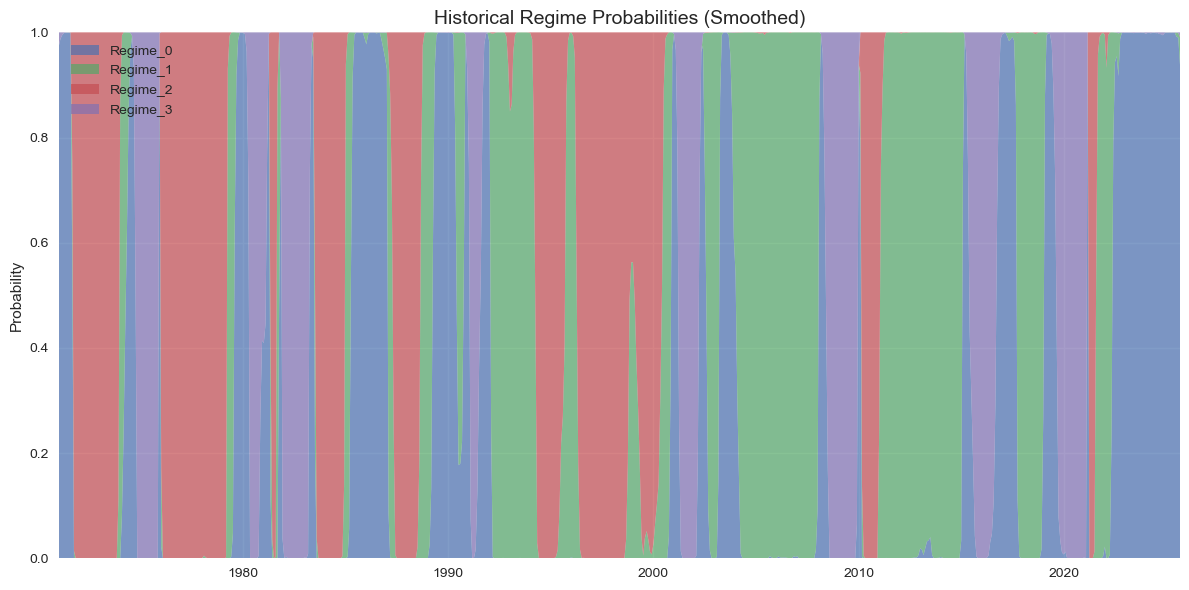

In [9]:
def plot_regime_timeline(macro_regime_df):
    """
    Stacked Area Chart of *smoothed* Regime Probabilities over time.

    This shows the history of the business cycle as "seen" by the model.
    Each color band represents one latent regime and its probability at time t.

    NOTE:
        This uses smoothed probabilities (ex-post view).
        For live decision-making, we would instead monitor filtered probabilities.
    """
    # Pick only the smoothed regime probability columns: 'Regime_0', 'Regime_1', ...
    prob_cols = [col for col in macro_regime_df.columns
                 if col.startswith("Regime_") and not col.startswith("Filt")]

    probs = macro_regime_df[prob_cols]

    fig, ax = plt.subplots(figsize=(12, 6))

    # Stacked area chart over time
    ax.stackplot(probs.index, probs.T, labels=prob_cols, alpha=0.7)

    ax.set_title("Historical Regime Probabilities (Smoothed)", fontsize=14)
    ax.set_ylabel("Probability")
    ax.set_xlim(probs.index[0], probs.index[-1])
    ax.set_ylim(0, 1.0)
    ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()


# Plot the regime timeline
plot_regime_timeline(macro_with_regimes)

In [10]:
def summarise_and_order_regimes(macro_regime_df):
    """
    Summarise each regime's average Growth and Inflation,
    then impose a systematic ordering by Growth.

    Steps:
        1. Group by the raw 'Regime' label from the HMM.
        2. Compute mean and std of growth_yoy and inflation_yoy.
        3. Sort regimes by mean growth_yoy (low -> high).
        4. Build a mapping from raw regime -> ordered index.
        5. Add a new column 'RegimeOrdered' using that mapping.

    Why this matters:
        - The HMM labels (0,1,2,3) are arbitrary.
        - Sorting by growth gives you a stable economic ordering:
            lowest Growth -> likely "Recession / Stagflation"
            highest Growth -> "Boom / Recovery" / "Goldilocks"
        - This avoids confusion if the underlying HMM relabels states
          between different runs or parameter tweaks.
    """

    # 1–2) Regime-level statistics
    summary = macro_regime_df.groupby("Regime")[["growth_yoy", "inflation_yoy"]].agg(["mean", "std"])

    # 3) Sort regimes by mean Growth (low -> high)
    summary_sorted = summary.sort_values(by=("growth_yoy", "mean"))

    print("\nMacro regime summary (sorted by Growth mean, low -> high):")
    print(summary_sorted)

    # 4) Build mapping from original regime -> ordered index
    ordered_regime_indices = list(summary_sorted.index)  # original regime labels, sorted by growth
    regime_order_map = {orig_regime: new_order for new_order, orig_regime in enumerate(ordered_regime_indices)}

    print("\nRegime ordering map (raw HMM label -> ordered index):")
    print(regime_order_map)

    # 5) Add ordered regime column
    macro_ordered = macro_regime_df.copy()
    macro_ordered["RegimeOrdered"] = macro_ordered["Regime"].map(regime_order_map)

    return macro_ordered, summary_sorted, regime_order_map

macro_with_regimes_ordered, regime_summary, regime_order_map = summarise_and_order_regimes(
    macro_with_regimes
)

print("\nFirst few rows with RegimeOrdered:")
print(macro_with_regimes_ordered[["growth_yoy", "inflation_yoy", "Regime", "RegimeOrdered"]].head())


Macro regime summary (sorted by Growth mean, low -> high):
       growth_yoy           inflation_yoy          
             mean       std          mean       std
Regime                                             
3       -5.803623  4.311522      4.063058  4.025087
0        0.264676  0.968030      4.148799  3.005500
1        2.832906  0.776407      3.308504  2.019457
2        6.624566  2.027344      4.044691  2.115578

Regime ordering map (raw HMM label -> ordered index):
{3: 0, 0: 1, 1: 2, 2: 3}

First few rows with RegimeOrdered:
            growth_yoy  inflation_yoy  Regime  RegimeOrdered
DATE                                                        
1971-01-01   -1.110239       5.142521       0              1
1971-02-01   -1.235151       4.616204       0              1
1971-03-01   -1.213541       4.342956       0              1
1971-04-01   -0.396045       4.071809       0              1
1971-05-01    0.226589       4.309919       0              1


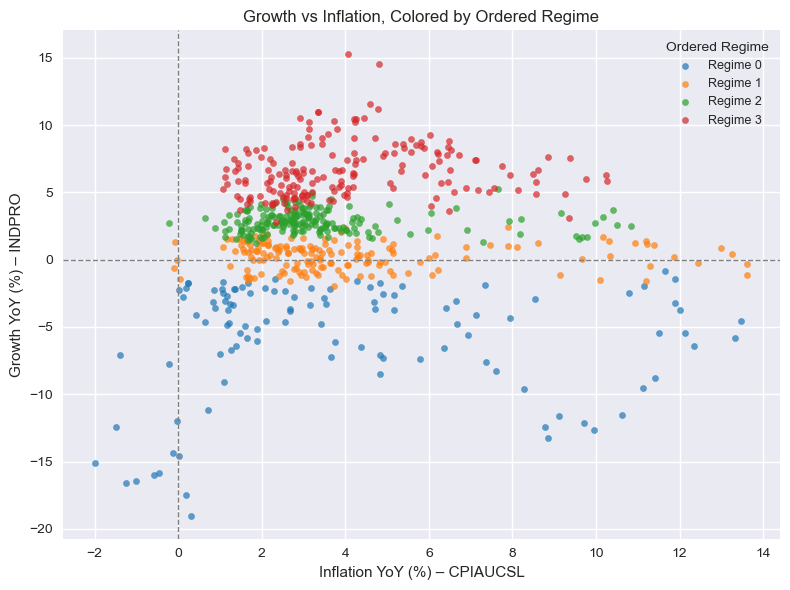

In [11]:
def plot_growth_inflation_scatter(macro_regime_df):
    """
    Growth vs Inflation scatter, colored by ordered regime.

    X-axis  : inflation_yoy (CPI YoY %)
    Y-axis  : growth_yoy (INDPRO YoY %)
    Color   : RegimeOrdered (0 = lowest growth, 3 = highest growth)

    This is the key visual that shows the HMM has discovered distinct
    macro clusters in Growth–Inflation space.
    """

    df = macro_regime_df.dropna(subset=["growth_yoy", "inflation_yoy", "RegimeOrdered"]).copy()

    fig, ax = plt.subplots(figsize=(8, 6))

    # Use a simple discrete colormap
    cmap = plt.get_cmap("tab10")

    for regime in sorted(df["RegimeOrdered"].unique()):
        subset = df[df["RegimeOrdered"] == regime]
        ax.scatter(
            subset["inflation_yoy"],
            subset["growth_yoy"],
            s=20,
            alpha=0.7,
            label=f"Regime {regime}",
            color=cmap(regime % 10)
        )

    # Zero lines to roughly indicate "above / below trend"
    ax.axvline(0.0, color="grey", linestyle="--", linewidth=1)
    ax.axhline(0.0, color="grey", linestyle="--", linewidth=1)

    ax.set_xlabel("Inflation YoY (%) – CPIAUCSL")
    ax.set_ylabel("Growth YoY (%) – INDPRO")
    ax.set_title("Growth vs Inflation, Colored by Ordered Regime")
    ax.legend(title="Ordered Regime", fontsize=9)

    plt.tight_layout()
    plt.show()


plot_growth_inflation_scatter(macro_with_regimes_ordered)

In [12]:
def add_regime_names(macro_regime_df):
    """
    Map ordered regime indices to human-readable macro regime names.

    NOTE:
        These labels are interpretive. You can refine them based on your
        own reading of history (1970s, 1980s, 2008, 2020, 2022 etc.).
    """
    regime_name_map = {
        0: "Crisis / Deep Recession",   # lowest growth regime
        1: "Slow Growth / Stagnation",
        2: "Expansion / Goldilocks",
        3: "Boom / Overheating"         # highest growth regime
    }

    df = macro_regime_df.copy()
    df["RegimeName"] = df["RegimeOrdered"].map(regime_name_map)

    # Quick count of months in each regime
    counts = df["RegimeName"].value_counts().sort_index()
    print("\nNumber of months in each named regime:")
    print(counts)

    return df, regime_name_map


macro_with_regimes_named, regime_name_map = add_regime_names(macro_with_regimes_ordered)

print("\nSample of RegimeName assignments:")
print(macro_with_regimes_named[["growth_yoy", "inflation_yoy", "RegimeOrdered", "RegimeName"]].head())


Number of months in each named regime:
RegimeName
Boom / Overheating          184
Crisis / Deep Recession     110
Expansion / Goldilocks      198
Slow Growth / Stagnation    165
Name: count, dtype: int64

Sample of RegimeName assignments:
            growth_yoy  inflation_yoy  RegimeOrdered                RegimeName
DATE                                                                          
1971-01-01   -1.110239       5.142521              1  Slow Growth / Stagnation
1971-02-01   -1.235151       4.616204              1  Slow Growth / Stagnation
1971-03-01   -1.213541       4.342956              1  Slow Growth / Stagnation
1971-04-01   -0.396045       4.071809              1  Slow Growth / Stagnation
1971-05-01    0.226589       4.309919              1  Slow Growth / Stagnation


In [13]:
import yfinance as yf

start_assets = "2007-05-01"
end_assets = None  # latest available
asset_list = ["SPY", "TLT", "HYG", "DBC", "GLD"]


def fetch_monthly_asset_returns(start_date=start_assets,
                                end_date=end_assets,
                                tickers=asset_list):
    """
    Fetch daily prices for the macro asset universe from Yahoo Finance,
    then convert them into monthly simple returns.

    Uses 'Adj Close' as a total-return-like series and resamples
    to month-end ('ME') to match monthly macro regimes.
    """
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=False,
        progress=False
    )

    if isinstance(data.columns, pd.MultiIndex):
        price_data = data["Adj Close"].copy()
    else:
        price_data = data["Adj Close"].to_frame()

    # Use 'ME' instead of 'M' for month-end
    monthly_prices = price_data.resample("ME").last()

    monthly_returns = monthly_prices.pct_change().dropna()
    return monthly_returns


asset_returns = fetch_monthly_asset_returns()

print("Monthly asset returns – first few rows:")
print(asset_returns.head())
print("\nReturn shape:", asset_returns.shape)

Monthly asset returns – first few rows:
Ticker           DBC       GLD       HYG       SPY       TLT
Date                                                        
2007-06-30  0.007448 -0.019378 -0.031525 -0.014621 -0.010135
2007-07-31  0.019066  0.023650 -0.038802 -0.031310  0.033190
2007-08-31 -0.019091  0.011096  0.051939  0.012833  0.017877
2007-09-30  0.094200  0.105081  0.029224  0.038714  0.002282
2007-10-31  0.085023  0.069514  0.004790  0.013566  0.018161

Return shape: (223, 5)


In [26]:
def align_returns_with_regimes(asset_returns, macro_regime_df, regime_col="RegimeOrdered"):
    """
    Updated to allow choosing between Smoothed (History) or Filtered (Trading) data.
    """
    ar = asset_returns.copy()
    ar["Period"] = ar.index.to_period("M")
    ar = ar.groupby("Period").last()

    mr = macro_regime_df[[regime_col, "RegimeName"]].copy()
    mr["Period"] = mr.index.to_period("M")
    mr = mr.groupby("Period").last()

    common_periods = ar.index.intersection(mr.index)
    aligned_returns = ar.loc[common_periods]
    aligned_regimes = mr.loc[common_periods, regime_col]
    
    return aligned_returns, aligned_regimes

In [27]:
def compute_regime_performance(returns, regimes, rf_annual=0.0):
    """
    Compute annualised return, volatility and Sharpe by regime for each asset.
    """
    # Align indices just in case
    returns, regimes = returns.align(regimes, join="inner", axis=0)

    df = returns.copy()
    df["Regime"] = regimes

    all_results = []

    for regime, group in df.groupby("Regime"):
        r = group[returns.columns]  # just the asset columns

        # Monthly stats
        mean_m = r.mean()
        vol_m = r.std()

        
        # Annualise
        ann_return = mean_m * 12.0
        ann_vol = vol_m * np.sqrt(12.0)

        excess_return = ann_return - rf_annual
        sharpe = excess_return / ann_vol

        regime_stats = pd.DataFrame({
            "Regime": regime,
            "Asset": mean_m.index,
            "AnnReturn": ann_return.values,
            "AnnVol": ann_vol.values,
            "Sharpe": sharpe.values
        })

        all_results.append(regime_stats)

    stats_df = pd.concat(all_results, ignore_index=True)
    return stats_df

# Calculate stats using the 'aligned_regimes' (Smoothed) from earlier in your script
asset_regime_stats = compute_regime_performance(
    aligned_returns,
    aligned_regimes,
    rf_annual=0.0
)

# Add names for readability
asset_regime_stats["RegimeName"] = asset_regime_stats["Regime"].map(regime_name_map)

print(asset_regime_stats.sort_values(["Regime", "Asset"]))

    Regime Asset  AnnReturn    AnnVol    Sharpe                RegimeName
0        0   DBC  -0.081039  0.258512 -0.313482   Crisis / Deep Recession
1        0   GLD   0.115944  0.204952  0.565714   Crisis / Deep Recession
2        0   HYG   0.049734  0.169232  0.293879   Crisis / Deep Recession
3        0   SPY   0.057428  0.208260  0.275753   Crisis / Deep Recession
4        0   TLT   0.058787  0.161246  0.364578   Crisis / Deep Recession
5        1   DBC   0.014344  0.134208  0.106881  Slow Growth / Stagnation
6        1   GLD   0.134920  0.143707  0.938861  Slow Growth / Stagnation
7        1   HYG   0.070047  0.070774  0.989722  Slow Growth / Stagnation
8        1   SPY   0.166640  0.136077  1.224598  Slow Growth / Stagnation
9        1   TLT  -0.022251  0.147059 -0.151306  Slow Growth / Stagnation
10       2   DBC   0.041499  0.171756  0.241615    Expansion / Goldilocks
11       2   GLD   0.060699  0.171731  0.353455    Expansion / Goldilocks
12       2   HYG   0.029140  0.075057 

In [28]:
def run_regime_backtest(returns, regimes, regime_map):
    """
    Simulates a portfolio that changes weights based on the macro regime.
    """
    # 1. Lag the Signal (Crucial for Real-Time Simulation)
    # We shift(1) so that Month T's portfolio is built using Month T-1's regime
    signal = regimes.shift(1).dropna() 
    
    # Align returns with the lagged signal
    common_idx = returns.index.intersection(signal.index)
    active_ret = returns.loc[common_idx]
    active_sig = signal.loc[common_idx]
    
    # 2. Benchmark (Equal Weight)
    n_assets = len(returns.columns)
    benchmark_ret = active_ret.mean(axis=1) 
    
    # 3. Strategy Calculation
    strategy_returns = []
    
    for period in active_ret.index:
        current_regime = active_sig.loc[period]
        
        # Get target weights; default to equal weight if missing
        weights_dict = regime_map.get(current_regime, {col: 1/n_assets for col in returns.columns})
        w_vector = np.array([weights_dict.get(col, 0.0) for col in active_ret.columns])
        
        # Portfolio return
        month_ret = np.dot(w_vector, active_ret.loc[period].values)
        strategy_returns.append(month_ret)
        
    # 4. Compile Results
    backtest_df = pd.DataFrame(index=active_ret.index)
    backtest_df['Strategy'] = strategy_returns
    backtest_df['Benchmark'] = benchmark_ret
    
    # Cumulative Returns
    backtest_df['Cum_Strategy'] = (1 + backtest_df['Strategy']).cumprod()
    backtest_df['Cum_Benchmark'] = (1 + backtest_df['Benchmark']).cumprod()
    
    return backtest_df

In [29]:
def plot_backtest_results(backtest_df):
    """
    Visualizes the equity curve of the regime strategy vs the benchmark.
    Assumes backtest_df has:
        - 'Cum_Strategy'
        - 'Cum_Benchmark'
        and a PeriodIndex or DatetimeIndex.
    """
    # Convert PeriodIndex -> Timestamp for plotting
    if hasattr(backtest_df.index, "to_timestamp"):
        x_index = backtest_df.index.to_timestamp()
    else:
        x_index = backtest_df.index

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x_index, backtest_df["Cum_Strategy"],
            label="Regime Macro Strategy", linewidth=2, color="navy")
    ax.plot(x_index, backtest_df["Cum_Benchmark"],
            label="Equal Weight Benchmark", linewidth=2,
            color="gray", linestyle="--")

    ax.set_title("Cumulative Performance: Macro Regime Model vs. Benchmark", fontsize=14)
    ax.set_ylabel("Growth of $1")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


FINAL BACKTEST RESULTS (Real-Time / Filtered)
             Strategy Benchmark
Total Return   349.1%    219.7%
Ann. Vol         9.9%      9.2%
Sharpe           0.88      0.74
Max Drawdown   -15.9%    -24.4%


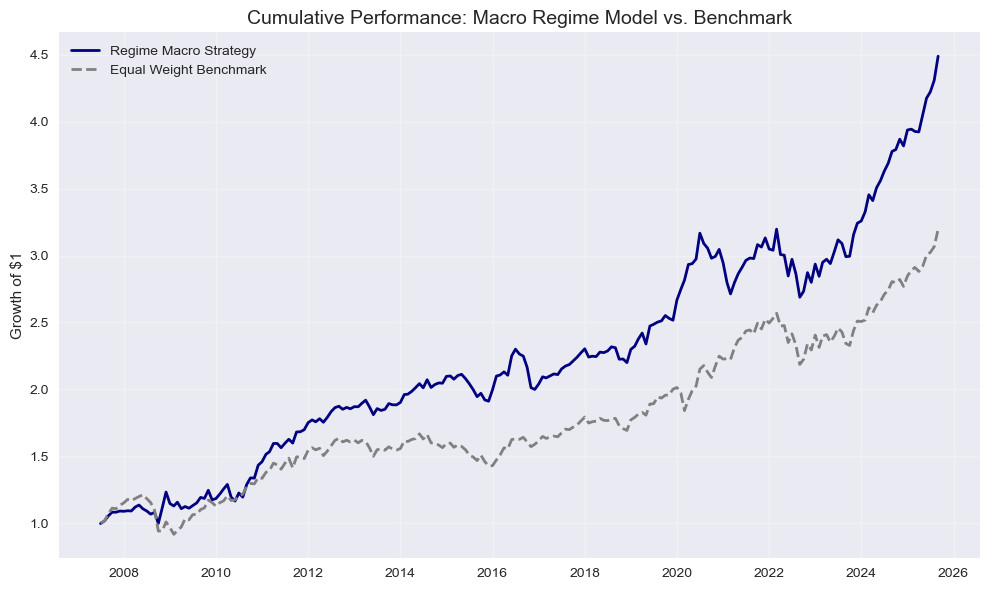

In [30]:
# Define Strategy Weights
regime_weights = {
    0: {'DBC': 0.0, 'GLD': 0.30, 'HYG': 0.0, 'SPY': 0.10, 'TLT': 0.60},   # Defensive / Crisis
    1: {'DBC': 0.10, 'GLD': 0.20, 'HYG': 0.30, 'SPY': 0.40, 'TLT': 0.0},  # Recovery / Risk-on
    2: {'DBC': 0.10, 'GLD': 0.10, 'HYG': 0.20, 'SPY': 0.30, 'TLT': 0.30}, # Balanced / Goldilocks
    3: {'DBC': 0.40, 'GLD': 0.10, 'HYG': 0.10, 'SPY': 0.40, 'TLT': 0.0}   # Inflation / Boom
}

# Create Real-Time (Filtered) Signal
# This prevents Look-Ahead Bias by using only data available at time t
filt_cols = [c for c in macro_with_regimes_named.columns if c.startswith("FiltRegime_")]

macro_with_regimes_named["RegimeFiltRaw"] = (
    macro_with_regimes_named[filt_cols]
    .idxmax(axis=1)
    .str.replace("FiltRegime_", "")
    .astype(int)
)

# Map to the same Economic Order (Crisis -> Boom)
macro_with_regimes_named["RegimeOrderedFilt"] = (
    macro_with_regimes_named["RegimeFiltRaw"].map(regime_order_map)
)

# 3. Align Data using the FILTERED column
aligned_returns_trading, aligned_regimes_trading = align_returns_with_regimes(
    asset_returns, 
    macro_with_regimes_named, 
    regime_col="RegimeOrderedFilt"  # Uses Filtered data
)

# 4. Run Backtest
backtest_results = run_regime_backtest(
    aligned_returns_trading, 
    aligned_regimes_trading, 
    regime_weights
)

# 5. Calculate Final Metrics
def calculate_final_metrics(backtest_df):
    stats = {}
    for col in ['Strategy', 'Benchmark']:
        series = backtest_df[col]
        cum_ret = (1 + series).cumprod()
        
        tot_ret = cum_ret.iloc[-1] - 1
        ann_vol = series.std() * np.sqrt(12)
        sharpe = (series.mean() / series.std()) * np.sqrt(12)
        max_dd = (cum_ret / cum_ret.cummax() - 1).min()
        
        stats[col] = {
            "Total Return": f"{tot_ret*100:.1f}%",
            "Ann. Vol": f"{ann_vol*100:.1f}%",
            "Sharpe": f"{sharpe:.2f}",
            "Max Drawdown": f"{max_dd*100:.1f}%"
        }
    return pd.DataFrame(stats)

print("\nFINAL BACKTEST RESULTS (Real-Time / Filtered)")
print(calculate_final_metrics(backtest_results))

plot_backtest_results(backtest_results)

In [31]:
def analyze_strategy_by_regime(backtest_df, regime_signal, regime_names):
    """
    Decomposes the Strategy vs Benchmark performance by Macro Regime.
    "Where is the Alpha coming from?"
    """
    # Merge Returns with Regime Signal
    df = backtest_df.copy()
    # Ensure indices align (intersection)
    common_idx = df.index.intersection(regime_signal.index)
    df = df.loc[common_idx]
    df['Regime'] = regime_signal.loc[common_idx]
    
    results = []
    
    for r_id in sorted(df['Regime'].unique()):
        subset = df[df['Regime'] == r_id]
        
        # Calculate annualized stats for this specific regime
        # (Note: we use simple scaling *12 and sqrt(12) for regime slices)
        
        # Strategy
        strat_ann_ret = subset['Strategy'].mean() * 12
        strat_ann_vol = subset['Strategy'].std() * np.sqrt(12)
        strat_sharpe = strat_ann_ret / strat_ann_vol if strat_ann_vol > 0 else 0
        
        # Benchmark
        bench_ann_ret = subset['Benchmark'].mean() * 12
        bench_ann_vol = subset['Benchmark'].std() * np.sqrt(12)
        bench_sharpe = bench_ann_ret / bench_ann_vol if bench_ann_vol > 0 else 0
        
        # Alpha
        alpha = strat_ann_ret - bench_ann_ret
        
        results.append({
            "Regime": regime_names.get(r_id, f"Regime {r_id}"),
            "Months": len(subset),
            "Strat Return": f"{strat_ann_ret*100:.1f}%",
            "Bench Return": f"{bench_ann_ret*100:.1f}%",
            "Alpha": f"{alpha*100:.1f}%",
            "Strat Sharpe": f"{strat_sharpe:.2f}",
            "Bench Sharpe": f"{bench_sharpe:.2f}"
        })
        
    return pd.DataFrame(results)

# Run the attribution
attribution_table = analyze_strategy_by_regime(
    backtest_results, 
    aligned_regimes_trading, 
    regime_name_map
)

print(attribution_table)

                     Regime  Months Strat Return Bench Return  Alpha  \
0   Crisis / Deep Recession      51         5.4%         5.6%  -0.2%   
1  Slow Growth / Stagnation      69        12.1%         8.6%   3.5%   
2    Expansion / Goldilocks      82         5.8%         3.8%   2.0%   
3        Boom / Overheating      17        19.4%        17.8%   1.6%   

  Strat Sharpe Bench Sharpe  
0         0.38         0.43  
1         1.60         1.18  
2         0.76         0.46  
3         1.52         2.82  


In [32]:
def compute_regime_correlations(returns, regimes, regime_names):
    """Calculates key correlations by regime."""
    df = returns.copy()
    df['Regime'] = regimes
    df = df.dropna()
    results = []
    
    for r_id in sorted(df['Regime'].unique()):
        subset = df[df['Regime'] == r_id].drop(columns=['Regime'])
        corr = subset.corr()
        results.append({
            "Regime": regime_names.get(r_id, f"Regime {r_id}"),
            "SPY-TLT": f"{corr.loc['SPY', 'TLT']:.2f}",
            "SPY-DBC": f"{corr.loc['SPY', 'DBC']:.2f}",
            "TLT-DBC": f"{corr.loc['TLT', 'DBC']:.2f}"
        })
    return pd.DataFrame(results)

# Use Smoothed regimes for historical correlation analysis
correlations = compute_regime_correlations(aligned_returns, aligned_regimes, regime_name_map)

print(correlations)

                     Regime SPY-TLT SPY-DBC TLT-DBC
0   Crisis / Deep Recession   -0.11    0.57   -0.31
1  Slow Growth / Stagnation    0.28    0.38   -0.20
2    Expansion / Goldilocks   -0.28    0.34   -0.45
3        Boom / Overheating   -0.71    0.86   -0.57
